<a href="https://colab.research.google.com/github/Tony-TTran/Tony-TTran/blob/main/Skin_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data Sets/Skin Cancer/HAM10000_metadata.csv', on_bad_lines='skip', engine="python")


Mounted at /content/drive


# **Preparing The Data**

In [ ]:
#The data we are primarly focused on when creating this classifier are the image_id and dx
#Image_id is the id of the image, dx is the corresponding label of that image
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [ ]:
data = data[['image_id','dx']]
data.head(5)

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl


In [ ]:
data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  10015 non-null  object
 1   dx        10015 non-null  object
dtypes: object(2)
memory usage: 156.6+ KB


In [ ]:
#Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec)
#basal cell carcinoma (bcc)
#benign keratosis-like lesions (bkl)
#dermatofibroma (df)
#melanoma (mel)
#melanocytic nevi (nv)
#vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc)
data['dx'].unique()
data = data.rename(columns = {'dx':'label'})

In [ ]:
#OneHotEncoded our labels
#encoded = pd.get_dummies(data['label'], prefix = 'label')
#data = data.merge(encoded,left_index=True, right_index=True)
#data = data.drop(['label'],axis = 1)
data

,image_id,label
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl
...,...,...
10010,ISIC_0033084,akiec
10011,ISIC_0033550,akiec
10012,ISIC_0033536,akiec
10013,ISIC_0032854,akiec


# **Organizing Images to Classified Folders**

In [ ]:
#Getting the path to our images
import os
image_file = ['HAM10000_images_part_1','HAM10000_images_part_2']
dir = '/content/drive/My Drive/Colab Notebooks/Data Sets/Skin Cancer/images'
image_paths = []

for fi in image_file:
  image_paths.append(os.path.join(dir,fi))


In [ ]:
#Creating new folders for each class
labels = data['label'].unique()
for label in labels:
  try:
    os.mkdir(os.path.join(dir,label))
  except:
    pass


In [ ]:
 #organizing the images to the appropriate folder based on labels from csv
 #iterate through all images and compare its id with the csv and move the image to the correct folder
import shutil

for path in image_paths:
  try:
    for image in os.listdir(path):
      image_id = image.replace(".jpg","")

      index = data[data['image_id'] == str(image_id)].index.values

      parameter = data['label'].loc[int(index)]

      match parameter:
        case 'bkl':
          shutil.move(os.path.join(path,image),os.path.join(dir,'bkl'))
        case 'nv':
          shutil.move(os.path.join(path,image),os.path.join(dir,'nv'))
        case 'df':
          shutil.move(os.path.join(path,image),os.path.join(dir,'df'))
        case 'mel':
          shutil.move(os.path.join(path,image),os.path.join(dir,'mel'))
        case 'vasc':
          shutil.move(os.path.join(path,image),os.path.join(dir,'vasc'))
        case 'bcc':
          shutil.move(os.path.join(path,image),os.path.join(dir,'bcc'))
        case 'akiec':
          shutil.move(os.path.join(path,image),os.path.join(dir,'akiec'))
        case _:
          pass
  except:
    pass


In [ ]:
#Delete HAM10000_images_part_1 and HAM10000_images_part_2 after all files are moved
for path in image_paths:
  try:
    os.rmdir(path)
  except:
    pass


# **Loading, Data Scaling and Splitting**

In [ ]:
import cv2
import imghdr
import tensorflow as tf
import keras
from keras import layers
from matplotlib import pyplot as plt

In [ ]:
tf.data.Dataset??

In [ ]:
#tf.keras.utils.image_dataset_from_directory will automatically lable all images based on folder name ie.classification
#the function will also resize all images to 256x256
#
#Labels should be sorted according to the alphanumeric order of the image file paths:
# 0 = akiec
# 1 = bcc
# 2 = bkl
# 3 = df
# 4 = mel
# 5 = nv
# 6 = vasc
full_data = tf.keras.utils.image_dataset_from_directory(dir,batch_size=10,image_size=(128, 128))

Found 10015 files belonging to 7 classes.


In [ ]:
print(len(full_data))

1002


In [ ]:
data = full_data.take(200)
print(len(data))

200


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

In [ ]:
#Batch of 32 (256x256)pixel images
batch[0].shape

(10, 128, 128, 3)

In [ ]:
#Each number corrisponds to a label
#32 labels, 1 for each image of the batch
batch[1]

array([5, 2, 4, 0, 1, 5, 5, 1, 5, 6], dtype=int32)

In [ ]:
#As data move through the pipeline, we normalize the images ie(make images in range from 0-1)
#Makes it faster for processing
data = data.map(lambda x, y: (x/255 , y))

In [ ]:
scaled_data_iterator = data.as_numpy_iterator()

In [ ]:
scaled_batch = scaled_data_iterator.next()

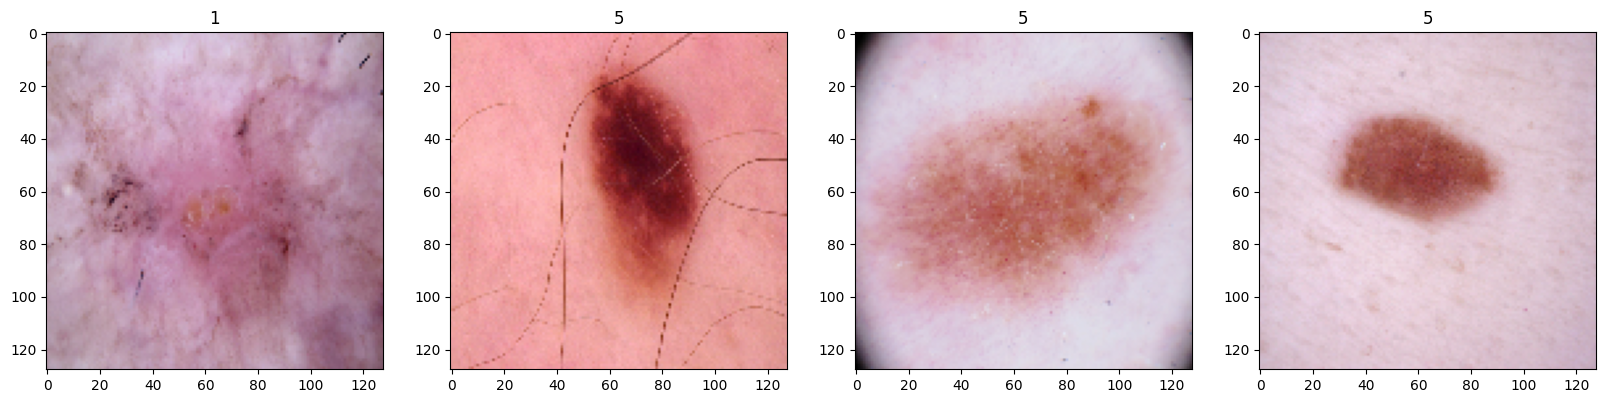

In [ ]:
fig, ax = plt.subplots(ncols = 4, figsize =(20,20))
for idx, img in enumerate(scaled_batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(scaled_batch[1][idx])

In [ ]:
#This function splits our data set into test, validation and training data sets
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(data,len(data))
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))
print(len(data))

160
20
20
200


# **Building the CNN**

In [ ]:
#Conv2D layer applies a filter to the image for edge detection, making it easier to find patterns for prediction
#MaxPooling2D condenses our image by taking max values of patches.
#Flatten allows us to drop from 2-dimensional(nxm) input to a single dimension (nmx1).
#Dense: fully connected layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(8, (3,3), 1, activation = 'relu', input_shape = (128,128,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3), 1, activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(8,(3,3), 1, activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))




In [ ]:
model.compile('adam', loss = tf.losses.SparseCategoricalCrossentropy(), metrics =['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 8)       224       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 8)       32        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 16)        1168      
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 16)        64        
 chNormalization)                                                
                                                        

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
#hist = model.fit(train_ds, epochs = 20,validation_data = val_ds)

In [ ]:
#model_path = '/content/drive/My Drive/Colab Notebooks/Data Sets/model'
#model.save(model_path)
#weight_path = '/content/drive/My Drive/Colab Notebooks/Data Sets/weight'
#model.save_weights(weight_path)

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Data Sets/Skin Cancer/model')

In [ ]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 8)       224       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 8)       32        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 16)        1168      
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 16)        64        
 chNormalization)                                                
                                                        

In [ ]:
results = new_model.evaluate(test_ds)
print('test loss, test acc: ', results)

20/20 [==============================] - 211s 36ms/step - loss: 1.2329 - accuracy: 0.7850
test loss, test acc:  [1.2329407930374146, 0.7850000262260437]


In [ ]:
prediction = new_model.predict(test_ds)

20/20 [==============================] - 23s 35ms/step


In [ ]:
prediction[0][:].argmax()

2

In [ ]:
print(prediction.shape)

(200, 7)
<_SkipDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
test_iterator = test_ds.as_numpy_iterator()
test_batch = test_iterator.next()

False
True
True
True
True


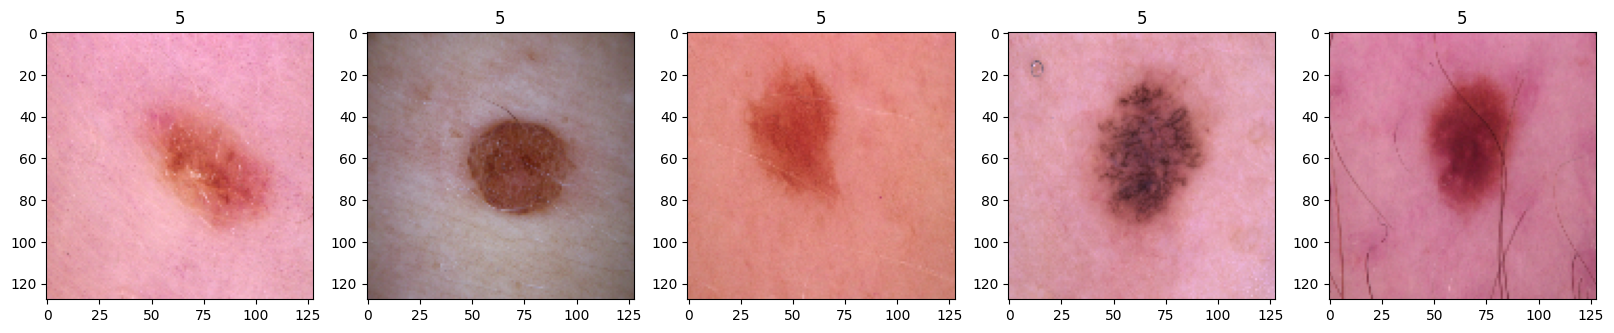

In [ ]:
fig, ax = plt.subplots(ncols = 5, figsize =(20,20))
for idx, img in enumerate(test_batch[0][:5]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(test_batch[1][idx])
  if(prediction[idx].argmax() == test_batch[1][idx]):
    print('True')
  else:
    print('False')

4